# Семинар 3. Обучение сверточных нейросетей в Pytorch

На этом семинаре мы будем обучать LeNet-5 на данных MNIST (и не только :). Мы наконец перестанем реализовывать все самостоятельно и будем пользоваться готовым функционалом pytorch.

Для начала ознакомимся с парой примеров обучения модели:
* [Пример 1](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py)
* [Пример 2](https://github.com/jcjohnson/pytorch-examples/blob/master/nn/two_layer_net_nn.py)

### Загрузка данных в pytorch

In [94]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data

In [95]:
from matplotlib import pyplot as plt
%matplotlib inline

В этот раз мы будем работать MNIST: он отличается от digits разрещением изображений (28x28 вместо 8x8) и числом объектов (60000 в обучении вместо 1797). 

В pytorch есть своя обертка, позволяющая скачивать MNIST, но нам будет удобнее скачать его самостоятельно.

In [96]:
from util import load_mnist

In [97]:
X_train, y_train, X_test, y_test = load_mnist()

Помимо обучающей и контрольной, нам понадобится валидационная выборка, чтобы настраивать гиперпараметры. Ее можно отделить от обучающей выборки (например, 25% = 15000 объектов). Однако модель несколько долго обучается даже на 75% обучающей выборки (несколько минут), что не очень хорошо для семинара. Поэтому для валидационных целей предлагается обучающую выборку также сжать до 15000 объектов. Финальную модель будем обучать по всей выборке.

In [98]:
# shuffle data
np.random.seed(0)
idxs = np.random.permutation(np.arange(X_train.shape[0]))
X_train, y_train = X_train[idxs], y_train[idxs]
                            
X_train.shape

(60000, 1, 28, 28)

В pytorch есть удобный класс для генерации батчей - DataLoader. Ему на вход надо подать объект класса TensorDataset, слудащий оберткой над матрицами данных.

In [99]:
def get_loader(X, y, batch_size=64):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), 
                                       torch.from_numpy(y))
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size)
    return train_loader

# for final model:
train_loader_full = get_loader(X_train, y_train) 
test_loader = get_loader(X_test, y_test)
# for validation purposes:
train_loader = get_loader(X_train[:15000], y_train[:15000])
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000])

In [100]:
# check number of objects
val_loader.dataset.tensors[0].shape

torch.Size([15000, 1, 28, 28])

### Задание модели LeNet-5

Сверточный слой (из презентации Антона Осокина):
![Слайд про свертки из презентации Антона Осокина](https://github.com/nadiinchi/dl_labs/raw/master/convolution.png)

Нам надо реализовать LeNet-5:

![Архитектура LeNet-5](https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/09/lenet-5-825x285.png?x64257)

Соберите нейросеть в соответствии с изображениями и примерами кода, которые были даны выше. В качестве нелинейности используйте ReLU (после всех сверточных и полносвязных слоев). Кроме того, нейросеть должна поддерживать увеличение числа сверток во всех сверточных слоях в k раз. 

Обратите внимание, что на схеме вход имеет размерность 32x32, а у нас - 28x28 (см. ячейку выше). Применять софтмакс в конце прохода вперед не нужно.

In [135]:
class CNN(nn.Module):
    def __init__(self, k=1):
        super(CNN, self).__init__()
        self.model_convolution_1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6 * k, kernel_size=(5,5), padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
        )
        
        self.model_convolution_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=6 * k, out_channels=16 * k, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
        )
        
        self.model_linear = torch.nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5 * k, out_features=120),
            nn.ReLU(),
            
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            
            nn.Linear(in_features=84, out_features=10),
        )
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward(self, input):
        output = self.model_convolution_1(input)
        output = self.model_convolution_2(output)
        output = output.view(-1, self.num_flat_features(output))
        output = self.model_linear(output)
        return output

Посчитаем параметры нейросети:

In [136]:
cnn = CNN()

In [137]:
def count_parameters(model):
    return sum(param.data.numpy().size for param \
               in model.parameters() if param.requires_grad)

count_parameters(cnn)

61706

### Обучение нейросети

Определим функцию потерь:

In [138]:
criterion = nn.CrossEntropyLoss() # loss includes softmax

Также определим устройство, на котором будем хранить данные и модель (cpu или gpu), и перенем на него модель:

In [139]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU
cnn = cnn.to(device)

Во время обучения модели удобно контролировать качество и на обучении, и на контроле (валидации) - возникает дублирующий код. Поэтому мы вынесем в отдельную функцию оценку модели, и в отдельную функцию - эпоху обучения. Это позволит также честно оценивать значение критерия качества на всей обучающей выборке по окончании эпохи (а не усреднять значения на минибатчах).

В прототипах указано про train и eval mode: в нашем случае они не нужны (были бы нужны, если бы мы использовали дропаут или батч-нормализацию, к примеру). Но чтобы вы могли использовать этот код в будущем, лучше указывать переключение режима.

In [140]:
def train_epoch(model, optimizer, train_loader, criterion, device='cpu'):
    """
    for each batch 
    performs forward and backward pass and parameters update 
    
    Input:
    model: instance of model (example defined above)
    optimizer: instance of optimizer (defined above)
    train_loader: instance of DataLoader
    
    Returns:
    nothing
    
    Do not forget to set net to train mode!
    """
    if optimizer:
        model.train()
    else:
        model.eval()
        
    for i, (batch_data, batch_target) in enumerate(train_loader):
        model.zero_grad()
        batch_output = model.forward(torch.tensor(batch_data))
        batch_loss = criterion(batch_output, torch.tensor(batch_target).long())
        batch_loss.backward()
        if optimizer:
            optimizer.step()
    
def evaluate_loss_acc(loader, model, criterion, device='cpu'):
    """
    Evaluates loss and accuracy on the whole dataset
    
    Input:
    loader:  instance of DataLoader
    model: instance of model (examle defined above)
    
    Returns:
    (loss, accuracy)
    
    Do not forget to set net to eval mode!
    """
    ### your code here
    model.eval()
    correct_matches, total_amount = 0, 0
    for i, (batch_data, batch_target) in enumerate(loader):
        batch_output = model.forward(torch.tensor(batch_data))
        batch_loss = criterion(batch_output, torch.tensor(batch_target).long())
        predicted_classes = torch.max(batch_output, dim=1)[1]
        
        total_amount = total_amount + len(predicted_classes)
        correct_matches = correct_matches + (predicted_classes == batch_target.data.long()).sum().item()
    
    if total_amount != 0:
        accuracy = correct_matches / int(total_amount)
    else:
        accuracy = 0
        
    return batch_loss, accuracy

    
def train(model, opt, train_loader, test_loader, criterion, n_epochs, \
          device='cpu', verbose=True):
    """
    Performs training of the model and prints progress
    
    Input:
    model: instance of model (example defined above)
    opt: instance of optimizer 
    train_loader: instance of DataLoader
    test_loader: instance of DataLoader (for evaluation)
    n_epochs: int
    
    Returns:
    4 lists: train_log, train_acc_log, val_log, val_acc_log
    with corresponding metrics per epoch
    """
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion, device)
        train_loss, train_acc = evaluate_loss_acc(train_loader, model, criterion, device)
        val_loss, val_acc = evaluate_loss_acc(test_loader, model, criterion, device)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
               ' Acc (train/test): %.4f/%.4f' )
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc))
            
    return train_log, train_acc_log, val_log, val_acc_log

In [141]:
### your code here
EPOCH_NUMBER = 20
MODEL = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(MODEL.parameters(), lr=0.001)

train_log_loss, train_accuracy_log_loss, eval_log_loss, eval_acc_log_loss = train(MODEL, optimizer, train_loader, val_loader, criterion, EPOCH_NUMBER, device="cpu")

Epoch [1/20], Loss (train/test): 0.2669/0.1205, Acc (train/test): 0.9307/0.9263
Epoch [2/20], Loss (train/test): 0.1286/0.0520, Acc (train/test): 0.9599/0.9533
Epoch [3/20], Loss (train/test): 0.0894/0.0247, Acc (train/test): 0.9707/0.9602
Epoch [4/20], Loss (train/test): 0.0552/0.0172, Acc (train/test): 0.9746/0.9631
Epoch [5/20], Loss (train/test): 0.0410/0.0115, Acc (train/test): 0.9774/0.9655
Epoch [6/20], Loss (train/test): 0.0310/0.0056, Acc (train/test): 0.9818/0.9688
Epoch [7/20], Loss (train/test): 0.0195/0.0022, Acc (train/test): 0.9843/0.9711
Epoch [8/20], Loss (train/test): 0.0136/0.0017, Acc (train/test): 0.9839/0.9706
Epoch [9/20], Loss (train/test): 0.0129/0.0031, Acc (train/test): 0.9839/0.9699
Epoch [10/20], Loss (train/test): 0.0137/0.0018, Acc (train/test): 0.9891/0.9749
Epoch [11/20], Loss (train/test): 0.0111/0.0051, Acc (train/test): 0.9909/0.9757
Epoch [12/20], Loss (train/test): 0.0105/0.0055, Acc (train/test): 0.9935/0.9767
Epoch [13/20], Loss (train/test): 0.0

Обучите нейронную сеть, используя определенные функции. Установите Adam в качестве оптимизатора, learning_rate=0.001, число эпох - 20. В качестве test_loader используйте валидационную выборку.

Визуализируем результат прохождения изображения через слои. Код ниже отрисовывает сетку изображений: первый столбец - изображения цифр, следующие 6 столбцов - результаты применения фильтров к ним. Чтобы им воспользоваться, сохраните в x переменную, храняющую батч из 10 изображений, в y - результат применения первого слоя к x.

In [193]:
### your code here
random_choice = np.random.choice(len(X_train), 10)
x = torch.from_numpy(X_train[random_choice].reshape(10, 1,28,28))
y = MODEL.model_convolution_1(x)

In [194]:
def plot(x, y):
    plt.figure(figsize=(15, 15))
    for im in range(10):
        plt.subplot(11, 7, im*7+1)
        plt.imshow(x.data[im, 0])
        plt.axis("off")
        for i in range(6):
            plt.subplot(11, 7, im*7+i+2)
            plt.imshow(y.data[im, i].numpy())
            plt.axis("off")

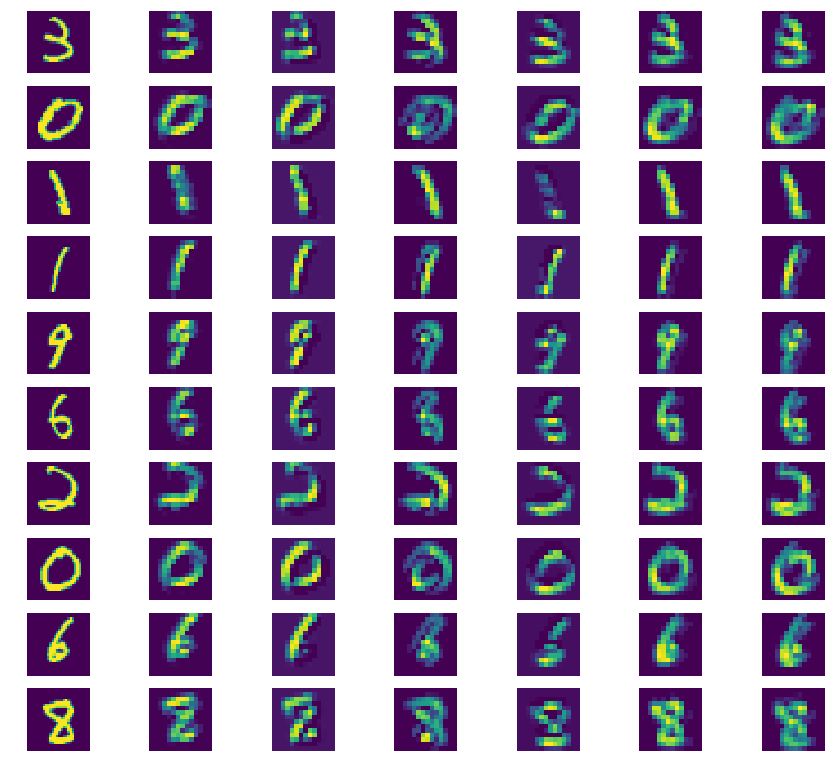

In [195]:
plot(x, y)

Затем визуализируйте результат применения второго сверточного слоя (после всех предыдущих слоев):

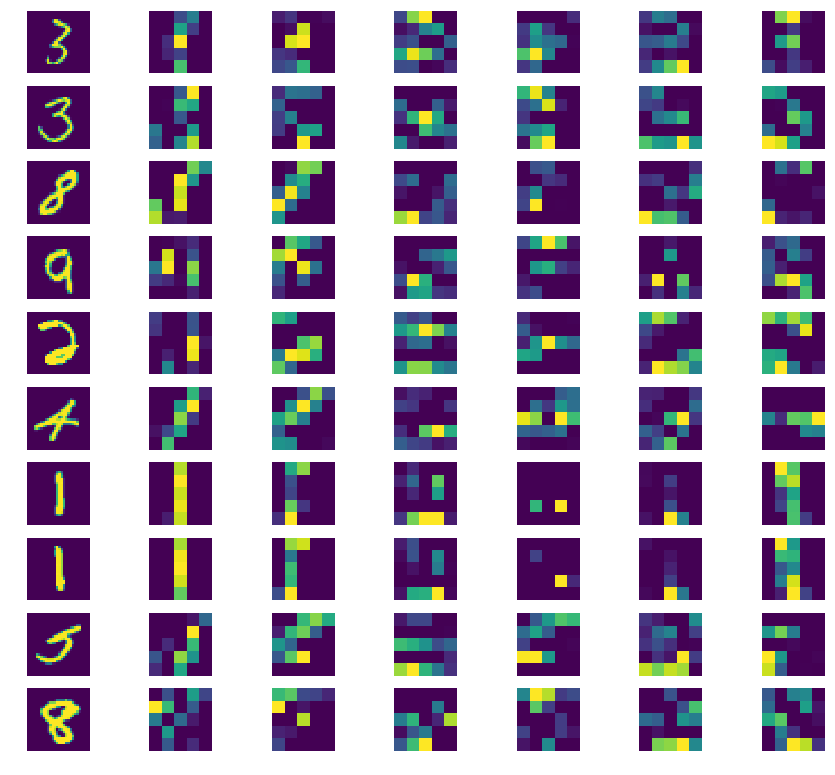

In [197]:
### your code here
random_choice = np.random.choice(len(X_train), 10)
x = torch.from_numpy(X_train[random_choice].reshape(10, 1,28,28))
y = MODEL.model_convolution_1(x)
y = MODEL.model_convolution_2(y)
plot(x, y)


### Подбор длины шага и размера батча

Постройте графики точности (accuracy) на обучающей и валидационной выборке в зависимости от номера эпохи при разных параметрах обучения: learning rate$ \in \{0.0001, 0.001, 0.01\}$, batch size $\in \{64, 256\}$. 

Лучше всего отображать кривые для обучения на левом графике, кривые для валидации - на правом с общей осью y (plt.ylim).

Как влияют длина шага и размер батча на итоговое качество?

In [199]:
### your code here
LEARNING_RATE = [0.0001, 0.001, 0.01]
BATCH_SIZE = [64, 256]
EPOCH_NUMBER = 20


exp_results = {}

for learning_rate in LEARNING_RATE:
    for batch_size in BATCH_SIZE:
        print("Learning rate:{}, Batch Size: {}".format(learning_rate, batch_size))
        ix = "LR_{}_BS_{}".format(learning_rate, batch_size)
        model = CNN()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        train_loader = get_loader(X_train[:20000], y_train[:20000], batch_size)
        val_loader = get_loader(X_train[20000:30000], y_train[20000:30000], batch_size)
        train_log_loss, train_accuracy_log_loss, eval_log_loss, eval_acc_log_loss = train(model, optimizer, train_loader, val_loader, criterion, EPOCH_NUMBER, device="cpu")
        exp_results[ix] = [train_accuracy_log_loss, eval_acc_log_loss]


Learning rate:0.0001, Batch Size: 64
Epoch [1/20], Loss (train/test): 0.6424/0.5909, Acc (train/test): 0.7974/0.7960
Epoch [2/20], Loss (train/test): 0.3574/0.2540, Acc (train/test): 0.8603/0.8549
Epoch [3/20], Loss (train/test): 0.2875/0.1763, Acc (train/test): 0.8827/0.8750
Epoch [4/20], Loss (train/test): 0.2559/0.1414, Acc (train/test): 0.8933/0.8877
Epoch [5/20], Loss (train/test): 0.2320/0.1293, Acc (train/test): 0.9033/0.8970
Epoch [6/20], Loss (train/test): 0.2130/0.1235, Acc (train/test): 0.9118/0.9049
Epoch [7/20], Loss (train/test): 0.1970/0.1199, Acc (train/test): 0.9195/0.9122
Epoch [8/20], Loss (train/test): 0.1834/0.1143, Acc (train/test): 0.9246/0.9179
Epoch [9/20], Loss (train/test): 0.1688/0.1070, Acc (train/test): 0.9303/0.9249
Epoch [10/20], Loss (train/test): 0.1611/0.0982, Acc (train/test): 0.9353/0.9299
Epoch [11/20], Loss (train/test): 0.1544/0.0887, Acc (train/test): 0.9396/0.9340
Epoch [12/20], Loss (train/test): 0.1459/0.0829, Acc (train/test): 0.9432/0.9370


Epoch [1/20], Loss (train/test): 0.0939/0.0336, Acc (train/test): 0.9354/0.9267
Epoch [2/20], Loss (train/test): 0.0157/0.0130, Acc (train/test): 0.9725/0.9641
Epoch [3/20], Loss (train/test): 0.0096/0.0717, Acc (train/test): 0.9646/0.9547
Epoch [4/20], Loss (train/test): 0.0062/0.0006, Acc (train/test): 0.9835/0.9704
Epoch [5/20], Loss (train/test): 0.0040/0.0016, Acc (train/test): 0.9858/0.9730
Epoch [6/20], Loss (train/test): 0.0024/0.0081, Acc (train/test): 0.9848/0.9738
Epoch [7/20], Loss (train/test): 0.0040/0.0000, Acc (train/test): 0.9846/0.9727
Epoch [8/20], Loss (train/test): 0.0015/0.0016, Acc (train/test): 0.9885/0.9754
Epoch [9/20], Loss (train/test): 0.0053/0.0003, Acc (train/test): 0.9736/0.9601
Epoch [10/20], Loss (train/test): 0.0003/0.0000, Acc (train/test): 0.9907/0.9763
Epoch [11/20], Loss (train/test): 0.0001/0.0000, Acc (train/test): 0.9931/0.9815
Epoch [12/20], Loss (train/test): 0.0015/0.0002, Acc (train/test): 0.9867/0.9715
Epoch [13/20], Loss (train/test): 0.0

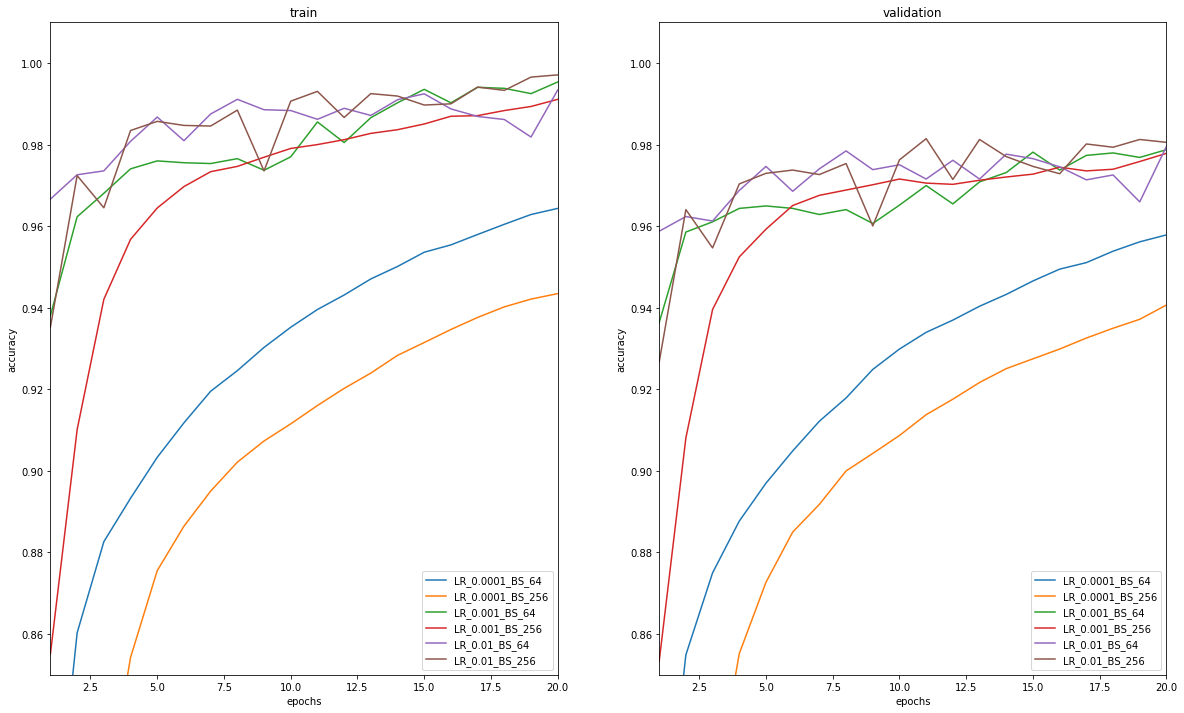

In [210]:
train_plot_data, test_plot_data = [], []
train_legend, test_legend = [], []

fig = plt.figure(figsize=(20,12))

ax0 = plt.subplot(121)
plt.ylim((0.85,1.01))
plt.xlim((1,20))
plt.title('train')
plt.ylabel('accuracy')
plt.xlabel('epochs')

ax1 = plt.subplot(122)
plt.ylim((0.85,1.01))
plt.xlim((1,20))
plt.title('validation')
plt.ylabel('accuracy')
plt.xlabel('epochs')

for exp_ix, exp_result in exp_results.items():
    y0, y1 = exp_result[0], exp_result[1]
    x = np.arange(1, EPOCH_NUMBER+1)
    train_plot, = ax0.plot(x, y0)
    test_plot, = ax1.plot(x, y1)
    train_legend.append(exp_ix)
    test_legend.append(exp_ix)
    train_plot_data.append(train_plot)
    test_plot_data.append(test_plot)

ax0.legend(train_plot_data, train_legend, loc='lower right')
ax1.legend(test_plot_data, test_legend, loc='lower right')

plt.show()

### Изменение архитектуры

Попробуйте модифицировать архитектуру нейросети: увеличить число фильтров и уменьшить число полносвязных слоев. 

Впишите цифры в скобки:
* LeNet-5 классич. (6 и 16 сверток):  качество на обучении: (0.9945)  качество на валидации: (0.9803)
* Увеличение в 4 раза (24 и 64 сверток):  качество на обучении: (0.99755)  качество на валидации: (0.9844)
* Удаление полносвзяного слоя: предыдущая нейросеть с 1 полносвязным слоем: качество на обучении: (0.69645)  качество на валидации: (0.6943)
    
    

In [200]:
### your code here
EPOCH_NUMBER = 20
model = CNN(k=1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = get_loader(X_train[:20000], y_train[:20000], 64)
val_loader = get_loader(X_train[20000:30000], y_train[20000:30000], 64)
train(model, optimizer, train_loader, val_loader, criterion, EPOCH_NUMBER, device="cpu")


Epoch [1/20], Loss (train/test): 0.1720/0.0878, Acc (train/test): 0.9440/0.9414
Epoch [2/20], Loss (train/test): 0.1181/0.0389, Acc (train/test): 0.9646/0.9610
Epoch [3/20], Loss (train/test): 0.0729/0.0332, Acc (train/test): 0.9676/0.9624
Epoch [4/20], Loss (train/test): 0.0477/0.0213, Acc (train/test): 0.9698/0.9621
Epoch [5/20], Loss (train/test): 0.0425/0.0097, Acc (train/test): 0.9734/0.9659
Epoch [6/20], Loss (train/test): 0.0349/0.0171, Acc (train/test): 0.9742/0.9648
Epoch [7/20], Loss (train/test): 0.0251/0.0068, Acc (train/test): 0.9817/0.9708
Epoch [8/20], Loss (train/test): 0.0388/0.0019, Acc (train/test): 0.9831/0.9717
Epoch [9/20], Loss (train/test): 0.0217/0.0016, Acc (train/test): 0.9793/0.9692
Epoch [10/20], Loss (train/test): 0.0145/0.0011, Acc (train/test): 0.9778/0.9678
Epoch [11/20], Loss (train/test): 0.0076/0.0012, Acc (train/test): 0.9832/0.9713
Epoch [12/20], Loss (train/test): 0.0064/0.0010, Acc (train/test): 0.9814/0.9692
Epoch [13/20], Loss (train/test): 0.0

([tensor(0.1720), tensor(0.1181), tensor(1.00000e-02 *
         7.2884), tensor(1.00000e-02 *
         4.7656), tensor(1.00000e-02 *
         4.2472), tensor(1.00000e-02 *
         3.4877), tensor(1.00000e-02 *
         2.5132), tensor(1.00000e-02 *
         3.8804), tensor(1.00000e-02 *
         2.1730), tensor(1.00000e-02 *
         1.4540), tensor(1.00000e-03 *
         7.6131), tensor(1.00000e-03 *
         6.4103), tensor(1.00000e-03 *
         4.0127), tensor(1.00000e-04 *
         6.4907), tensor(1.00000e-03 *
         2.1552), tensor(1.00000e-03 *
         4.0423), tensor(1.00000e-04 *
         8.4102), tensor(1.00000e-03 *
         2.3564), tensor(1.00000e-03 *
         6.6884), tensor(1.00000e-03 *
         1.4317)],
 [0.944,
  0.96455,
  0.9676,
  0.96975,
  0.9734,
  0.9742,
  0.9817,
  0.98315,
  0.9793,
  0.97775,
  0.9832,
  0.9814,
  0.9862,
  0.9885,
  0.99155,
  0.99485,
  0.99315,
  0.99155,
  0.99075,
  0.9945],
 [tensor(1.00000e-02 *
         8.7789), tensor(1.0000

In [201]:
### your code here
EPOCH_NUMBER = 20
model = CNN(k=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = get_loader(X_train[:20000], y_train[:20000], 64)
val_loader = get_loader(X_train[20000:30000], y_train[20000:30000], 64)
train(model, optimizer, train_loader, val_loader, criterion, EPOCH_NUMBER, device="cpu")


Epoch [1/20], Loss (train/test): 0.0498/0.0585, Acc (train/test): 0.9627/0.9588
Epoch [2/20], Loss (train/test): 0.0385/0.0278, Acc (train/test): 0.9766/0.9684
Epoch [3/20], Loss (train/test): 0.0253/0.0451, Acc (train/test): 0.9758/0.9653
Epoch [4/20], Loss (train/test): 0.0406/0.0291, Acc (train/test): 0.9689/0.9577
Epoch [5/20], Loss (train/test): 0.0199/0.0046, Acc (train/test): 0.9793/0.9668
Epoch [6/20], Loss (train/test): 0.0104/0.0010, Acc (train/test): 0.9759/0.9633
Epoch [7/20], Loss (train/test): 0.0126/0.0006, Acc (train/test): 0.9752/0.9605
Epoch [8/20], Loss (train/test): 0.0023/0.0001, Acc (train/test): 0.9833/0.9699
Epoch [9/20], Loss (train/test): 0.0076/0.0001, Acc (train/test): 0.9866/0.9722
Epoch [10/20], Loss (train/test): 0.0006/0.0001, Acc (train/test): 0.9929/0.9810
Epoch [11/20], Loss (train/test): 0.0073/0.0000, Acc (train/test): 0.9853/0.9714
Epoch [12/20], Loss (train/test): 0.0019/0.0000, Acc (train/test): 0.9977/0.9834
Epoch [13/20], Loss (train/test): 0.0

([tensor(1.00000e-02 *
         4.9752), tensor(1.00000e-02 *
         3.8543), tensor(1.00000e-02 *
         2.5268), tensor(1.00000e-02 *
         4.0592), tensor(1.00000e-02 *
         1.9903), tensor(1.00000e-02 *
         1.0395), tensor(1.00000e-02 *
         1.2639), tensor(1.00000e-03 *
         2.2528), tensor(1.00000e-03 *
         7.5787), tensor(1.00000e-04 *
         5.8617), tensor(1.00000e-03 *
         7.3231), tensor(1.00000e-03 *
         1.8674), tensor(1.00000e-03 *
         7.3882), tensor(1.00000e-04 *
         6.3801), tensor(1.00000e-04 *
         1.9236), tensor(1.00000e-05 *
         5.4295), tensor(1.00000e-04 *
         9.3384), tensor(1.00000e-04 *
         7.0994), tensor(1.00000e-04 *
         1.0874), tensor(1.00000e-04 *
         1.8010)],
 [0.96275,
  0.9766,
  0.9758,
  0.96895,
  0.9793,
  0.9759,
  0.9752,
  0.9833,
  0.98655,
  0.99295,
  0.9853,
  0.99765,
  0.9938,
  0.99255,
  0.9966,
  0.99655,
  0.99385,
  0.99625,
  0.9942,
  0.99755],
 [tens

In [204]:
class CNNWithoutFullConnectedLayers(nn.Module):
    def __init__(self, k=1):
        super(CNNWithoutFullConnectedLayers, self).__init__()
        self.model_convolution_1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6 * k, kernel_size=(5,5), padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
        )
        
        self.model_convolution_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=6 * k, out_channels=16 * k, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
        )
        
        self.model_linear = torch.nn.Sequential(
            nn.Linear(in_features=16 * 5 * 5 * k, out_features=120),
            nn.ReLU(),
        )
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward(self, input):
        output = self.model_convolution_1(input)
        output = self.model_convolution_2(output)
        output = output.view(-1, self.num_flat_features(output))
        output = self.model_linear(output)
        return output

In [205]:
### your code here
EPOCH_NUMBER = 20
model = CNNWithoutFullConnectedLayers(k=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = get_loader(X_train[:20000], y_train[:20000], 64)
val_loader = get_loader(X_train[20000:30000], y_train[20000:30000], 64)
train(model, optimizer, train_loader, val_loader, criterion, EPOCH_NUMBER, device="cpu")


Epoch [1/20], Loss (train/test): 1.2441/0.6222, Acc (train/test): 0.6765/0.6797
Epoch [2/20], Loss (train/test): 1.1635/0.6054, Acc (train/test): 0.6821/0.6842
Epoch [3/20], Loss (train/test): 1.1068/0.6034, Acc (train/test): 0.6834/0.6844
Epoch [4/20], Loss (train/test): 1.0820/0.6011, Acc (train/test): 0.6829/0.6833
Epoch [5/20], Loss (train/test): 1.0705/0.5996, Acc (train/test): 0.6864/0.6859
Epoch [6/20], Loss (train/test): 1.0660/0.5990, Acc (train/test): 0.6885/0.6888
Epoch [7/20], Loss (train/test): 1.0589/0.5986, Acc (train/test): 0.6921/0.6917
Epoch [8/20], Loss (train/test): 1.0594/0.5986, Acc (train/test): 0.6934/0.6920
Epoch [9/20], Loss (train/test): 1.0534/0.5991, Acc (train/test): 0.6940/0.6934
Epoch [10/20], Loss (train/test): 1.0522/0.5993, Acc (train/test): 0.6949/0.6936
Epoch [11/20], Loss (train/test): 1.0514/0.5990, Acc (train/test): 0.6937/0.6915
Epoch [12/20], Loss (train/test): 1.0561/0.6042, Acc (train/test): 0.6947/0.6936
Epoch [13/20], Loss (train/test): 1.0

([tensor(1.2441),
  tensor(1.1635),
  tensor(1.1068),
  tensor(1.0820),
  tensor(1.0705),
  tensor(1.0660),
  tensor(1.0589),
  tensor(1.0594),
  tensor(1.0534),
  tensor(1.0522),
  tensor(1.0514),
  tensor(1.0561),
  tensor(1.0491),
  tensor(1.0524),
  tensor(1.0480),
  tensor(1.0507),
  tensor(1.0499),
  tensor(1.0473),
  tensor(1.0480),
  tensor(1.0480)],
 [0.6765,
  0.68205,
  0.68335,
  0.68295,
  0.6864,
  0.6885,
  0.69205,
  0.6934,
  0.694,
  0.69495,
  0.6937,
  0.6947,
  0.6933,
  0.69425,
  0.6937,
  0.69015,
  0.69555,
  0.69465,
  0.69435,
  0.69645],
 [tensor(0.6222),
  tensor(0.6054),
  tensor(0.6034),
  tensor(0.6011),
  tensor(0.5996),
  tensor(0.5990),
  tensor(0.5986),
  tensor(0.5986),
  tensor(0.5991),
  tensor(0.5993),
  tensor(0.5990),
  tensor(0.6042),
  tensor(0.6008),
  tensor(0.5991),
  tensor(0.5986),
  tensor(0.5990),
  tensor(0.5995),
  tensor(0.5984),
  tensor(0.5985),
  tensor(0.5984)],
 [0.6797,
  0.6842,
  0.6844,
  0.6833,
  0.6859,
  0.6888,
  0.691

Выберите длину шага, размер батча и архитектуру по валидационной выборке, обучите нейросеть на полной обучающей выборке и выведите качество на контрольной выборке. Хуже ли оно, чем на валидационной выборке?

In [212]:
train_loader_full = get_loader(X_train, y_train, 64) 
test_loader = get_loader(X_test, y_test, 64)

In [213]:
### your code here
EPOCH_NUMBER = 20
model = CNN(k=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer, train_loader_full, test_loader, criterion, EPOCH_NUMBER, device="cpu")


Epoch [1/20], Loss (train/test): 0.0380/0.0022, Acc (train/test): 0.9821/0.9823
Epoch [2/20], Loss (train/test): 0.0070/0.0004, Acc (train/test): 0.9896/0.9867
Epoch [3/20], Loss (train/test): 0.0039/0.0002, Acc (train/test): 0.9931/0.9902
Epoch [4/20], Loss (train/test): 0.0013/0.0002, Acc (train/test): 0.9939/0.9913
Epoch [5/20], Loss (train/test): 0.0004/0.0004, Acc (train/test): 0.9954/0.9913
Epoch [6/20], Loss (train/test): 0.0006/0.0009, Acc (train/test): 0.9963/0.9915
Epoch [7/20], Loss (train/test): 0.0026/0.0000, Acc (train/test): 0.9961/0.9910
Epoch [8/20], Loss (train/test): 0.0028/0.0000, Acc (train/test): 0.9963/0.9912
Epoch [9/20], Loss (train/test): 0.0016/0.0000, Acc (train/test): 0.9968/0.9911
Epoch [10/20], Loss (train/test): 0.0007/0.0010, Acc (train/test): 0.9970/0.9909
Epoch [11/20], Loss (train/test): 0.0000/0.0000, Acc (train/test): 0.9972/0.9902
Epoch [12/20], Loss (train/test): 0.0001/0.0000, Acc (train/test): 0.9980/0.9901
Epoch [13/20], Loss (train/test): 0.0

([tensor(1.00000e-02 *
         3.8018), tensor(1.00000e-03 *
         7.0398), tensor(1.00000e-03 *
         3.9000), tensor(1.00000e-03 *
         1.2508), tensor(1.00000e-04 *
         4.0293), tensor(1.00000e-04 *
         6.2582), tensor(1.00000e-03 *
         2.6197), tensor(1.00000e-03 *
         2.8193), tensor(1.00000e-03 *
         1.5658), tensor(1.00000e-04 *
         7.4070), tensor(1.00000e-06 *
         6.1786), tensor(1.00000e-04 *
         1.2026), tensor(1.00000e-04 *
         5.3234), tensor(1.00000e-05 *
         2.0562), tensor(1.00000e-06 *
         6.2402), tensor(1.00000e-07 *
         4.0837), tensor(1.00000e-04 *
         5.9389), tensor(1.00000e-04 *
         1.5254), tensor(1.00000e-06 *
         5.1350), tensor(1.00000e-06 *
         1.1389)],
 [0.9821333333333333,
  0.9895666666666667,
  0.9930666666666667,
  0.9939,
  0.9953666666666666,
  0.9962833333333333,
  0.9960666666666667,
  0.9962666666666666,
  0.9968,
  0.9969666666666667,
  0.9971833333333333,

0.984 на валидационной vs 0.989 на контрольной - я считаю то же самое в данном эксперименте в пределах погрешности